## Supervise.ly base64 bitmap to polygon

In [1]:
import cv2
from PIL import Image, ImageDraw
import zlib
import numpy as np
import io
import json
import base64
from skimage import io as skio
from skimage import measure
from skimage.measure import approximate_polygon, find_contours
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union

https://docs.supervise.ly/data-organization/import-export/supervisely-format#bitmap


In [2]:
def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3]
    return mask

def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

In [3]:
with open('Castelo_Branco1/castelo_branco1.jpg.json','r') as f:
    annotations = json.load(f)

In [4]:
full_image = skio.imread('Castelo_Branco1/castelo_branco1.jpg')

In [5]:
for ii,ob in enumerate(annotations['objects']):
    print(ii, ob['id'], ob['geometryType'])
    if ii > 15: break

0 512654159 bitmap
1 516187759 bitmap
2 516187762 bitmap
3 516187764 bitmap
4 516187779 bitmap
5 516187796 bitmap
6 517734573 bitmap
7 517744467 bitmap
8 525646939 bitmap
9 525647021 bitmap
10 530256172 bitmap
11 530256302 polygon
12 530256378 polygon
13 530256708 polygon
14 530256159 bitmap
15 530272342 bitmap
16 530272463 bitmap


### Try to find regions with holes

In [6]:
for ii,ob in enumerate(annotations['objects']):
    if ob['geometryType'] == 'bitmap':
        img = base64_2_mask(ob['bitmap']['data'])

        img_embed = np.zeros(tuple(x+2 for x in img.shape))
        img_embed[1:-1,1:-1] = img

        contours = measure.find_contours(img_embed, 127)
        if len(contours) > 1:
            print(ii, len(contours))


10 2
31 2
60 2
62 2
83 29
93 2
95 3
117 2
161 3
162 3
212 18


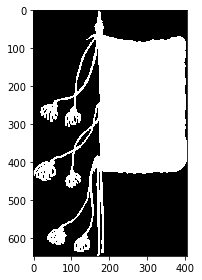

In [7]:
ob = annotations['objects'][83]
bitmap = ob['bitmap']
mask = base64_2_mask(bitmap['data'])
origin = bitmap['origin']
skio.imshow(mask);

In [8]:
type(mask)

numpy.ndarray

## Tracing bitmaps

https://stackoverflow.com/questions/58340068/fully-convert-a-black-and-white-image-to-a-set-of-lines-aka-vectorize-using-onl

This particular method for contours and plotting:
https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html


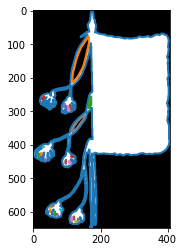

In [9]:
img = mask

# embed image away from image boundaries
img_embed = np.zeros(tuple(x+2 for x in img.shape))
img_embed[1:-1,1:-1] = img

contours = measure.find_contours(img_embed, 128)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(img_embed, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
plt.show()

orig 7455 pts :  appr 1343 pts :  appr 531 pts


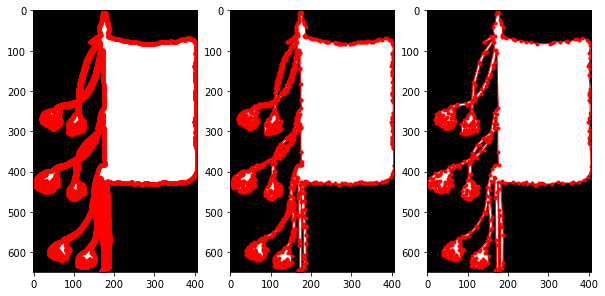

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10))

# embed image away from image boundaries
img_embed = np.zeros(tuple(x+2 for x in img.shape))
img_embed[1:-1,1:-1] = img

# Full-resolution contours
contours = measure.find_contours(img_embed, 127)
ax1.imshow(img_embed, cmap=plt.cm.gray)
for contour in contours:
    ax1.plot(contour[:, 1], contour[:, 0], 'r.-', linewidth=1)
ax1.axis('image')

# Approximation 1
poly1_list = []
for contour in contours:
    poly1_list.append(approximate_polygon(contour, tolerance=0.5))
ax2.imshow(img_embed, cmap=plt.cm.gray)
for contour in poly1_list:
    ax2.plot(contour[:, 1], contour[:, 0], 'r.-', linewidth=1)
ax2.axis('image')

# Approximation 2
poly2_list = []
for contour in contours:
    poly2_list.append(approximate_polygon(contour, tolerance=1.0))
ax3.imshow(img_embed, cmap=plt.cm.gray)
for contour in poly2_list:
    ax3.plot(contour[:, 1], contour[:, 0], 'r.-', linewidth=1)
ax3.axis('image')

print('orig', sum([len(x) for x in contours]), 'pts : ',
      'appr', sum([len(x) for x in poly1_list]), 'pts : ',
      'appr', sum([len(x) for x in poly2_list]), 'pts')

plt.show()


---

### Polygon union to get rid of holes

https://stackoverflow.com/questions/26389524/how-do-i-add-two-polygons-in-python-using-shapely

https://shapely.readthedocs.io/en/latest/manual.html#shapely.ops.unary_union

In [11]:
poly2_list[1]

array([[214.        , 118.49803922],
       [196.        , 133.49803922],
       [167.        , 148.49803922],
       [ 98.        , 165.49803922],
       [ 78.50196078, 165.        ],
       [ 79.        , 162.50196078],
       [103.        , 147.50196078],
       [104.        , 145.50196078],
       [134.        , 131.50196078],
       [186.        , 117.50196078],
       [214.        , 116.50196078],
       [214.        , 118.49803922]])

#### Excluding anything that's not a polygon

In [12]:
sh_poly2_list = [Polygon(x) for x in poly2_list if len(x) > 2]

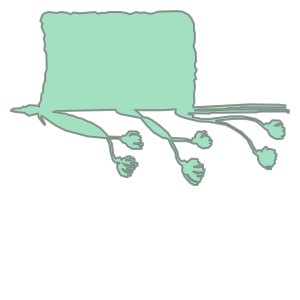

In [13]:
poly2_union = unary_union(sh_poly2_list)
poly2_union

### Grab coordinates

Don't really need repeated coordinate at end, but I don't think it'll hurt, either.

https://stackoverflow.com/questions/20474549/extract-points-coordinates-from-a-polygon-in-shapely

**Note: The problematic part here is that it will connect multiple disconnected polygons into one, so a path will be drawn between them...**

In [14]:
print(poly2_union.type)

if poly2_union.type == 'MultiPolygon':
    ar_list = []
    for poly in poly2_union:
        ar_list.append(np.array(poly.exterior))
    coords = np.concatenate(ar_list, axis=0)
elif poly2_union.type == 'Polygon':
    coords = np.array(poly2_union.exterior)
else:
    print('problem type')

Polygon


### Remember we need to eventually subtract 1

Because of the single-pixel buffer we created to surround the bitmap

#### Need to add origin backwards? 

Check for real...

In [15]:
real_coords = (coords.round(2)-1) + np.array([origin[1],origin[0]])
real_coords[:5].tolist()

[[1284.0, 2158.5],
 [1224.0, 2158.5],
 [1212.0, 2156.5],
 [1107.0, 2155.5],
 [1105.0, 2153.5]]

In [24]:
np.flip(real_coords, axis=1)[:5].tolist()

[[2158.5, 1284.0],
 [2158.5, 1224.0],
 [2156.5, 1212.0],
 [2155.5, 1107.0],
 [2153.5, 1105.0]]

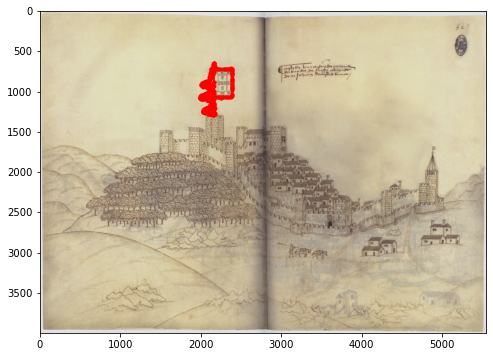

In [16]:
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=[8,8])
ax.imshow(full_image, cmap=plt.cm.gray)

ax.plot(real_coords[:, 1], real_coords[:, 0], 'r.-', linewidth=2)

ax.axis('image')
plt.show()

In [17]:
bitmap = ob.pop('bitmap')
ob

{'id': 520967115,
 'classId': 1525944,
 'description': '',
 'geometryType': 'bitmap',
 'labelerLogin': 'alirothberg',
 'createdAt': '2020-09-23T20:05:46.916Z',
 'updatedAt': '2020-11-24T15:27:44.879Z',
 'tags': [{'id': 101277769,
   'tagId': 27898700,
   'name': '* Flag shape',
   'value': 'Rectangular',
   'labelerLogin': 'alirothberg',
   'createdAt': '2020-09-23T20:41:44.371Z',
   'updatedAt': '2020-09-23T20:41:44.371Z'},
  {'id': 101277768,
   'tagId': 27898698,
   'name': '* Flag Affiliation',
   'value': 'Portugal',
   'labelerLogin': 'alirothberg',
   'createdAt': '2020-09-23T20:41:39.289Z',
   'updatedAt': '2020-09-23T20:41:39.289Z'}],
 'classTitle': 'Flag'}

In [18]:
ob['geometryType'] = 'polygon'
ob['points'] = {'exterior':[], 'interior':[]}
ob

{'id': 520967115,
 'classId': 1525944,
 'description': '',
 'geometryType': 'polygon',
 'labelerLogin': 'alirothberg',
 'createdAt': '2020-09-23T20:05:46.916Z',
 'updatedAt': '2020-11-24T15:27:44.879Z',
 'tags': [{'id': 101277769,
   'tagId': 27898700,
   'name': '* Flag shape',
   'value': 'Rectangular',
   'labelerLogin': 'alirothberg',
   'createdAt': '2020-09-23T20:41:44.371Z',
   'updatedAt': '2020-09-23T20:41:44.371Z'},
  {'id': 101277768,
   'tagId': 27898698,
   'name': '* Flag Affiliation',
   'value': 'Portugal',
   'labelerLogin': 'alirothberg',
   'createdAt': '2020-09-23T20:41:39.289Z',
   'updatedAt': '2020-09-23T20:41:39.289Z'}],
 'classTitle': 'Flag',
 'points': {'exterior': [], 'interior': []}}

### Need to check XY order!

In [19]:
ob['points']['exterior'] = real_coords.tolist()
ob

{'id': 520967115,
 'classId': 1525944,
 'description': '',
 'geometryType': 'polygon',
 'labelerLogin': 'alirothberg',
 'createdAt': '2020-09-23T20:05:46.916Z',
 'updatedAt': '2020-11-24T15:27:44.879Z',
 'tags': [{'id': 101277769,
   'tagId': 27898700,
   'name': '* Flag shape',
   'value': 'Rectangular',
   'labelerLogin': 'alirothberg',
   'createdAt': '2020-09-23T20:41:44.371Z',
   'updatedAt': '2020-09-23T20:41:44.371Z'},
  {'id': 101277768,
   'tagId': 27898698,
   'name': '* Flag Affiliation',
   'value': 'Portugal',
   'labelerLogin': 'alirothberg',
   'createdAt': '2020-09-23T20:41:39.289Z',
   'updatedAt': '2020-09-23T20:41:39.289Z'}],
 'classTitle': 'Flag',
 'points': {'exterior': [[1284.0, 2158.5],
   [1224.0, 2158.5],
   [1212.0, 2156.5],
   [1107.0, 2155.5],
   [1105.0, 2153.5],
   [1058.0, 2154.5],
   [1056.5, 2153.0],
   [1067.0, 2150.5],
   [1066.0, 2145.5],
   [1087.0, 2141.5],
   [1105.0, 2141.5],
   [1154.0, 2147.5],
   [1183.0, 2147.5],
   [1212.0, 2141.5],
   [1223